In [2]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.0.0rc1

In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import os
import random
from pathlib import Path

import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import DirectedGraphSAGELinkGenerator, DirectedGraphSAGENodeGenerator
from stellargraph.layer import DirectedGraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras
import tensorflow as tf
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import accuracy_score

from stellargraph import globalvar

from stellargraph import datasets
from IPython.display import display, HTML

if tf.test.gpu_device_name():
  print('Default GPU Device:{}'.format(tf.test.gpu_device_name()))

Default GPU Device:/device:GPU:0


### Loading the TF network data

In [5]:
DATA_FOLDER = Path("../../data/")
FILE_NAME = 'GM12878_PPI_sample_ver1.csv'
SEP = ','

df = pd.read_csv(DATA_FOLDER / FILE_NAME, sep=SEP)[['cell_type', 'source', 'target', 'weight', 'type']]
df

,cell_type,source,target,weight,type
0,GM12878,MEF2C,ISG15,137.000000,TSS
1,GM12878,MEF2C,NADK,230.679062,TSS
2,GM12878,MEF2C,TMEM201,114.340787,TSS
3,GM12878,MEF2C,VPS13D,169.000000,TSS
4,GM12878,MEF2C,UBR4,98.051176,TSS
...,...,...,...,...,...
22634,GM12878,YAE1D1,VIM,NaN,PPI
22635,GM12878,WIPF1,WASL,NaN,PPI
22636,GM12878,WIPF2,WAS,NaN,PPI
22637,GM12878,WWOX,WIPF2,NaN,PPI


In [6]:
# Explore the tf2gene section of the network
tf2gene = df[df['type'] == 'TSS']
nx_graph = nx.from_pandas_edgelist(tf2gene[['source', 'target', 'weight']], 'source', 'target', edge_attr='weight', create_using=nx.DiGraph)
print(nx.info(nx_graph))

Name: 
Type: DiGraph
Number of nodes: 1186
Number of edges: 4283
Average in degree:   3.6113
Average out degree:   3.6113


**use 1 as features**

In [7]:
source_nodes = set(df['source'])
target_nodes = set(df['target'])
nodes = source_nodes.union(target_nodes)
feature = dict(zip(list(nodes), [1 for _ in range(len(nodes))]))
feature_df = pd.DataFrame.from_dict(feature, orient='index')
print(f'Number of nodes: {len(nodes)}')

Number of nodes: 7927


In [8]:
feature_df

,0
SLCO4C1,1
LPCAT2,1
FXR2,1
SPCS3,1
BROX,1
...,...
HIST2H3D,1
DDR1,1
PFDN4,1
KLC1,1


In [7]:
G = sg.StellarDiGraph(edges=df[['source', 'target']], nodes=feature_df)
print(G.info())


StellarDiGraph: Directed multigraph
 Nodes: 2497, Edges: 9407

 Node types:
  default: [2497]
    Features: float32 vector, length 1
    Edge types: default-default->default

 Edge types:
    default-default->default: [9407]
        Weights: all 1 (default)


In [8]:
G.nodes()

Index(['MAPT', 'SPTBN1', 'GOLGA8A', 'PELP1', 'SMAD4', 'ABL1', 'AR', 'SPAG8',
       'SCIMP', 'ATF4',
       ...
       'STRAP', 'OAS1', 'NFYB', 'MED29', 'TRAPPC5', 'SYT5', 'KCNJ12', 'RIF1',
       'SNTB1', 'KLRC4-KLRK1'],
      dtype='object', length=2497)

**1. Specify the other optional parameter values: root nodes, the number of walks to take per node, the length of each walk, and random seed.**

In [9]:
nodes = list(G.nodes())
number_of_walks = 6 #
length = 3 # Too much

SEED = 0

**2. Create the UnsupervisedSampler instance with the relevant parameters passed to it.**

In [10]:
biased_walker = sg.data.BiasedRandomWalk(G, n=number_of_walks, length=length, p=2, q=.5, seed=SEED)

unsupervised_samples = UnsupervisedSampler(
    G, nodes=nodes, walker=biased_walker
)

In [11]:
# unsupervised_samples.run(2)

**3. Create a node pair generator:**

Next, create the node pair generator for sampling and streaming the training data to the model. The node pair generator essentially "maps" pairs of nodes `(target, context)` to the input of GraphSAGE: it either takes minibatches of node pairs, or an `UnsupervisedSampler` instance which generates the minibatches of node pairs on demand. The generator samples 2-hop subgraphs with `(target, context)` head nodes extracted from those pairs, and feeds them, together with the corresponding binary labels indicating which pair represent positive or negative sample, to the input layer of the node pair classifier with GraphSAGE node encoder, for SGD updates of the model parameters.

Specify:
1. The minibatch size (number of node pairs per minibatch).
2. The number of epochs for training the model.
3. The sizes of 1- and 2-hop neighbor samples for GraphSAGE:

Note that the length of `num_samples` list defines the number of layers/iterations in the GraphSAGE encoder. In this example, we are defining a 2-layer GraphSAGE encoder.

In [12]:
batch_size = 256
epochs = 50
in_samples = [5, 5, 5]
out_samples = [5, 5, 5]

In the following we show the working of node pair generator with the UnsupervisedSampler, which will generate samples on demand.

In [13]:
generator = DirectedGraphSAGELinkGenerator(G, batch_size, in_samples=in_samples, out_samples=out_samples, seed=SEED)
train_gen = generator.flow(unsupervised_samples)


Build the model: a 2-layer GraphSAGE encoder acting as node representation learner, with a link classification layer on concatenated (`citing-paper`, `cited-paper`) node embeddings.

GraphSAGE part of the model, with hidden layer sizes of 50 for both GraphSAGE layers, a bias term, and no dropout. (Dropout can be switched on by specifying a positive dropout rate, 0 < dropout < 1).
**Note that the length of `layer_sizes` list must be equal to the length of `num_samples`, as `len(num_samples)` defines the number of hops (layers) in the GraphSAGE encoder**.

In [14]:
layer_sizes = [32, 32, 32]
graphsage = DirectedGraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.3, normalize="l2", aggregator=sg.layer.MeanAggregator
)

In [15]:
# Build the model and expose input and output sockets of graphsage, for node pair inputs:
x_inp, x_out = graphsage.in_out_tensors()

In [16]:
prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="concat"
)(x_out)

link_classification: using 'concat' method to combine node embeddings into edge embeddings


In [17]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=1e-4),
    loss=keras.losses.binary_crossentropy,
    metrics=['binary_accuracy'],
)

In [18]:
# checkpoint
filepath="./checkpoints/test/weights-improvement-{epoch:02d}-{binary_accuracy:.2f}.hdf5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(str(filepath), 
                             monitor='binary_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=True,
                             mode='auto')
callbacks_list = [checkpoint]

**4. Train the model.**

In [19]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=1,
    use_multiprocessing=False,
    workers=8,
    shuffle=True,
    callbacks=callbacks_list
)

  ...
    to  
  ['...']
Train for 235 steps
Epoch 1/50
234/235 [============================>.] - ETA: 1s - loss: 0.6908 - binary_accuracy: 0.5155  - ETA: 6 - ETA: 4:21 - loss: 0. - ETA: 3:25 - loss: 0.6915 - ETA: 2:37 - loss: 0.6914 - binary_accuracy: 0.512 - ETA: 2:35 - loss: 0.6913 - binary_accuracy: 0.512 - ETA: 2:32 - loss: 0.6 - ETA: 1:42 - loss: 0.
Epoch 00001: binary_accuracy improved from -inf to 0.51527, saving model to ./checkpoints/test/weights-improvement-01-0.52.hdf5
235/235 [==============================] - 375s 2s/step - loss: 0.6909 - binary_accuracy: 0.5153
Epoch 2/50
234/235 [============================>.] - ETA: 1s - loss: 0.6890 - binary_accuracy: 0.5215  ETA
Epoch 00002: binary_accuracy improved from 0.51527 to 0.52168, saving model to ./checkpoints/test/weights-improvement-02-0.52.hdf5
235/235 [==============================] - 395s 2s/step - loss: 0.6890 - binary_accuracy: 0.5217
Epoch 3/50
234/235 [============================>.] - ETA: 1s - loss: 0.6859 - b

### Extracting node embeddings
Now that the node pair classifier is trained, we can use its node encoder part as node embeddings evaluator. Below we evaluate node embeddings as activations of the output of graphsage layer stack, and visualise them, coloring nodes by their subject label.

In [20]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from stellargraph.mapper import GraphSAGENodeGenerator
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

**Building a new node-based model**

The `(src, dst)` node pair classifier `model` has two identical node encoders: one for source nodes in the node pairs, the other for destination nodes in the node pairs passed to the model. We can use either of the two identical encoders to evaluate node embeddings. Below we create an embedding model by defining a new Keras model with `x_inp_src` (a list of odd elements in `x_inp`) and `x_out_src` (the 1st element in `x_out`) as input and output, respectively. Note that this model's weights are the same as those of the corresponding node encoder in the previously trained node pair classifier.

In [21]:
x_inp_src = x_inp[0::2]
x_out_src = x_out[0]
embedding_model = keras.Model(inputs=x_inp_src, outputs=x_out_src)

In [22]:
print(x_inp_src)

[<tf.Tensor 'input_1:0' shape=(None, 1, 1) dtype=float32>, <tf.Tensor 'input_2:0' shape=(None, 5, 1) dtype=float32>, <tf.Tensor 'input_3:0' shape=(None, 5, 1) dtype=float32>, <tf.Tensor 'input_4:0' shape=(None, 25, 1) dtype=float32>, <tf.Tensor 'input_5:0' shape=(None, 25, 1) dtype=float32>, <tf.Tensor 'input_6:0' shape=(None, 25, 1) dtype=float32>, <tf.Tensor 'input_7:0' shape=(None, 25, 1) dtype=float32>, <tf.Tensor 'input_8:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_9:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_10:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_11:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_12:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_13:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_14:0' shape=(None, 125, 1) dtype=float32>, <tf.Tensor 'input_15:0' shape=(None, 125, 1) dtype=float32>]


We also need a node generator to feed graph nodes to `embedding_model`. We want to evaluate node embeddings for all nodes in the graph:

In [23]:
df

,cell_type,source,target,weight,type
0,GM12878,BCL3,MRPL20,55.002413,TSS
1,GM12878,BCL3,CDK11A,206.122635,TSS
2,GM12878,BCL3,TNFRSF14,190.000000,TSS
3,GM12878,BCL3,NPHP4,149.679014,TSS
4,GM12878,BCL3,KCNAB2,404.296705,TSS
...,...,...,...,...,...
9402,GM12878,ZNF446,ZNF397,NaN,PPI
9403,GM12878,ZNF408,ZNF408,NaN,PPI
9404,GM12878,ZNF446,ZNF434,NaN,PPI
9405,GM12878,ZNF496,ZNF446,NaN,PPI


In [28]:
node_ids = feature_df.index
node_gen = DirectedGraphSAGENodeGenerator(G, batch_size, in_samples=in_samples, out_samples=out_samples).flow(node_ids)

In [29]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

10/10 [==============================] - 8s 796ms/step


#### Visualize the node embeddings 
Next we visualize the node embeddings in 2D using t-SNE. Colors of the nodes depict their true classes (subject in the case of Cora dataset) of the nodes. 

In [30]:
# node_subject = node_subjects.astype("category").cat.codes

X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
#     emb_transformed["label"] = node_subject
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})
#     emb_transformed["label"] = node_subject

In [46]:
tfs = set(tf2gene['source'])
print(tfs)

def geneType(name):
    if name in tfs:
        return 1   # 1 represents TFs
    else:
        return 0   # 2 represents normal genes

{'BCL3', 'POLR2AphosphoS2', 'NFE2', 'NFYA', 'JUNB', 'NRF1', 'SIX5', 'RAD21', 'NBN'}


In [50]:
emb_transformed['type'] = emb_transformed.index.map(geneType)


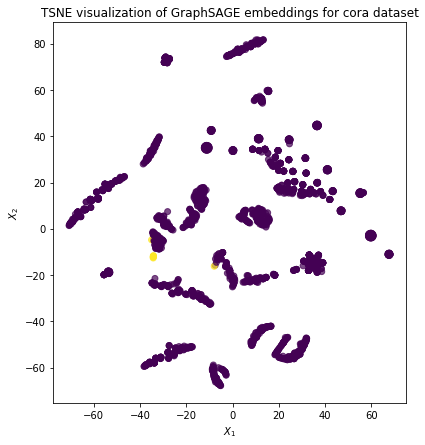

In [52]:
alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["type"].astype("category"),
#     cmap="jet",
    alpha=alpha,
)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title(
    "{} visualization of GraphSAGE embeddings for cora dataset".format(transform.__name__)
)
plt.show()

In [ ]:
emb_transformed.head()